In [225]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from wordcloud import WordCloud
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, plot_confusion_matrix, plot_roc_curve
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, roc_auc_score, cohen_kappa_score
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier

###  <font color='navy'>Data Exploration </font>

In [226]:
# read imdb movie review sentiment file into pandas
imdb_reviews = pd.read_csv('IMDB Dataset.csv')
imdb_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [227]:
# the reviews have html tags. double quotations, brackets, hyphen etc that should be removed in preprocessing.
imdb_reviews.iloc[1, 0]

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well d

In [228]:
# examine the dataframe
imdb_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
review       50000 non-null object
sentiment    50000 non-null object
dtypes: object(2)
memory usage: 781.4+ KB


In [229]:
# the dataset is balanced with 25K positive and 25k negative reviews
print(imdb_reviews.sentiment.value_counts())
print(imdb_reviews.sentiment.value_counts(normalize=True))

positive    25000
negative    25000
Name: sentiment, dtype: int64
positive    0.5
negative    0.5
Name: sentiment, dtype: float64


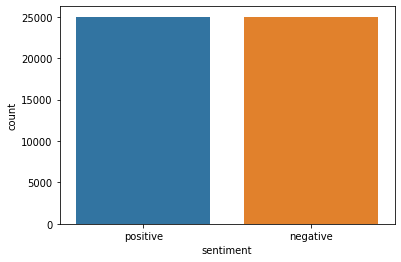

In [230]:
# plot the positive / negative classes as frequencies
sns.countplot(x='sentiment', data=imdb_reviews)
plt.show()

In [231]:
# longest, shortest and avg review lengths
review_length = imdb_reviews.review.str.len()
print('longest review is', review_length.max(), 'chracters long')
print('shortest review is',review_length.min(), 'chracters long')
print('average review is ',int(review_length.mean()), 'chracters long')

longest review is 13704 chracters long
shortest review is 32 chracters long
average review is  1309 chracters long


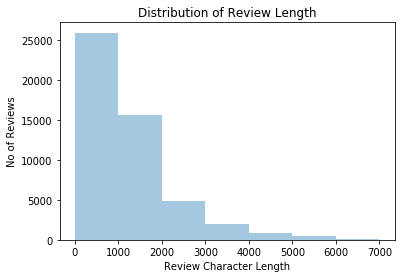

In [232]:
s = sns.distplot(review_length, bins=[0,1000,2000,3000,4000,5000,6000,7000], kde=False)
s.set_xlabel('Review Character Length')
s.set_ylabel('No of Reviews')
s.set_title('Distribution of Review Length')
plt.show()

###  <font color='navy'>Pre processing </font>

In [233]:
# convert sentiment into numerical as sklearn expects target variable to be numeric

# define a 1-1 mapping from string to numeric
mapping = {'positive' :1, 'negative' : 0}
imdb_reviews['sentiment'] = imdb_reviews.sentiment.map(mapping)

In [234]:
# check the target column is mapped correctly
imdb_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [235]:
# Text processing steps

#convert everything to lower case
imdb_reviews['review'] = imdb_reviews.review.str.lower()

# remove numbers 
imdb_reviews['review'] = imdb_reviews.review.str.replace('[0-9]+', '') # match one or more digits

# remove html tags
regex_html = r'<\s*[^>]*>|<\s*/\s*>' #this regular exression will match all html tags
imdb_reviews['review'] = imdb_reviews.review.str.replace(regex_html, '')

# remove Punctuations
regex_punctuations = r'[^\w\s]' #match anything not a digit/letter/underscore or space
imdb_reviews['review'] = imdb_reviews.review.str.replace(regex_punctuations, '')
imdb_reviews['review'] = imdb_reviews.review.str.replace('_', '')  # remove underscore too

In [236]:
imdb_reviews['review'].head()

0    one of the other reviewers has mentioned that ...
1    a wonderful little production the filming tech...
2    i thought this was a wonderful way to spend ti...
3    basically theres a family where a little boy j...
4    petter matteis love in the time of money is a ...
Name: review, dtype: object

In [237]:
# Instantiate the CountVectorizer
countvec = CountVectorizer(stop_words=ENGLISH_STOP_WORDS)
bag = countvec.fit_transform(imdb_reviews.review)

In [238]:
# look at the dimensions of the sparse matrix
bag.shape
# vocabulary of 214K is too big , lets try to reduce this

(50000, 214525)

##### <b>*Stemming* </b>

In [239]:
# stemmer will only work on tokenized words not sentences. We will define a function to do this. 
def getRootWords(sentence) :
    #instantiate stemmer 
    stemmer=SnowballStemmer("english") # the english stemmer is an improvement on the original porter stemmer
    
    #tokenize the sentence
    tokens = word_tokenize(sentence)
    
    # stem the tokens
    root_tokens= [stemmer.stem(word) for word in tokens]
    
    # join words together to form sentence again 
    root_sentence = ' '.join(root_tokens)
    
    return root_sentence

In [240]:
#  Stemming Example: watching, watch, watched =>'watch' and movie, movies +> movi
sentence = '''I love wathching movies. I have watched over 50 movies since the lockdown began. In fact I will watch one movie tonight'''
getRootWords(sentence)

'i love wathch movi . i have watch over 50 movi sinc the lockdown began . in fact i will watch one movi tonight'

In [241]:
# stem each review to reduce the vocabulary 
imdb_reviews['review'] = imdb_reviews.review.apply(getRootWords)

In [242]:
# if we stem text then we must stem stopwords too
stemmer=SnowballStemmer("english")
stop_words_stemmed = [stemmer.stem(word) for word in ENGLISH_STOP_WORDS]

In [243]:
# see how many words changed from iriginal stop words
print(set(stop_words_stemmed).difference(ENGLISH_STOP_WORDS))

{'nobodi', 'onli', 'befor', 'cri', 'thereaft', 'pleas', 'becaus', 'anoth', 'whenev', 'alreadi', 'besid', 'sinc', 'perhap', 'elsewher', 'hundr', 'afterward', 'therebi', 'themselv', 'empti', 'meanwhil', 'anywher', 'sever', 'forti', 'everywher', 'togeth', 'sometim', 'somewher', 'sincer', 'howev', 'whatev', 'anyth', 'ani', 'els', 'wherebi', 'onc', 'ourselv', 'becom', 'becam', 'describ', 'thenc', 'otherwis', 'whenc', 'henc', 'twelv', 'therefor', 'nowher', 'mani', 'alway', 'dure', 'fifti', 'someth', 'anyon', 'hereaft', 'sixti', 'herebi', 'noth', 'wherea', 'someon', 'everyth', 'whereaft', 'noon', 'everyon', 'everi', 'moreov', 'inde', 'yourselv', 'twenti', 'alon', 'wherev', 'veri', 'whi', 'abov'}


In [244]:
# stemmed bag of words
countvec_stem= CountVectorizer(stop_words=stop_words_stemmed)
bag_stem = countvec_stem.fit_transform(imdb_reviews.review)
bag_stem.shape

(50000, 174181)

*Stemming has reduced no of features from 214K to 174K, so a significant reduction*

In [245]:
# create a word cloud
corpus = imdb_reviews.review.str.cat(sep=' ') #concat all reviews into one big string
word_cloud= WordCloud(background_color='white', stopwords=stop_words_stemmed,collocations=False).generate(corpus)

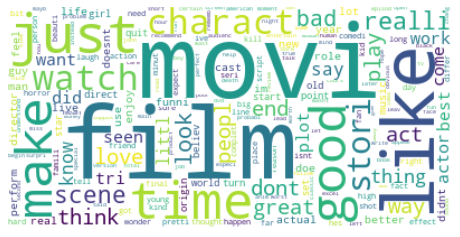

In [246]:
# Display the generated wordcloud image (both postive and negative)
plt.figure(figsize=(8,5)) 
plt.imshow(word_cloud, interpolation='bilinear') 
plt.axis("off")
plt.show()

In [247]:
# split the dataframe into positive and negative reviews
positive_reviews = imdb_reviews[imdb_reviews.sentiment == 1] # positive sentiment
negative_reviews = imdb_reviews[imdb_reviews.sentiment == 0] # negative sentiment

In [248]:
#generate positive and negative word clouds
positive_corpus = positive_reviews.review.str.cat(sep=' ')
positive_word_cloud= WordCloud(background_color='white', stopwords=stop_words_stemmed,collocations=False).generate(positive_corpus)

negative_corpus = negative_reviews.review.str.cat(sep=' ')
negative_word_cloud= WordCloud(background_color='white',stopwords=stop_words_stemmed, collocations=False).generate(negative_corpus)

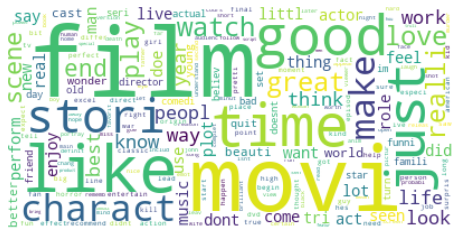

In [249]:
# show the positive wordcloud image
plt.figure(figsize=(8,5))
plt.imshow(positive_word_cloud, interpolation='bilinear') 
plt.axis("off")
plt.show()

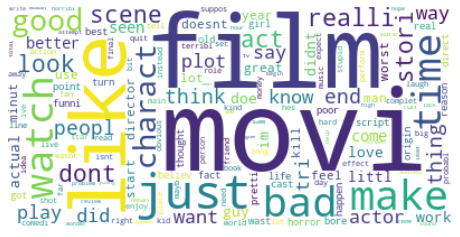

In [250]:
# show the negative wordcloud image
plt.figure(figsize=(8,5))
plt.imshow(negative_word_cloud, interpolation='bilinear') 
plt.axis("off")
plt.show()

##### <b>*Context & ngrams* </b>

In [251]:
print(len(stop_words_stemmed))

# update the stop_words to include a few words that may make the context clearer (eg: not not good, not bad etc)
mylist = ['not', 'never', 'alway', 'interest']
for word in mylist : 
    stop_words_stemmed.remove(word)

#remove a few movie related stopwords 
movie_related_stopwords = ['movi', 'film', 'act', 'watch', 'scene']
stop_words_stemmed = stop_words_stemmed + movie_related_stopwords
# print the no of updated stopwords
print(len(stop_words_stemmed))

318
319


In [252]:
# Define X and target 
X = imdb_reviews.review
y = imdb_reviews.sentiment.values # as numpy array

In [253]:
#split the data into training and test sets 
# Note this step is done even before Vectorizing the reviews(text). 
SEED = 1411 # for reproducibility

# 80% training 20% test, balanced dataset (50% pos, 50% neg) so no need to split in a stratified fashion
X_data_train, X_data_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

###  <font color='navy'>I.  Train and Compare ML Models using Bag-of-Words </font>

In [254]:
# max no of features (unigrams and bigrams)
MAX_FEATURES=2500 # roughly 1% of the total unigrams

#  build a vocabulary that only considers the top max_features ordered by term frequency across the corpus
countvec = CountVectorizer(max_features=MAX_FEATURES, stop_words=stop_words_stemmed, ngram_range=(1,2))
bag = countvec.fit_transform(X_data_train) 

# Create X_train and X_test
X_train_bow= bag.toarray() # scikit learn cant work with sparse matrices, so convert bag of words to numpy array

# No refitting. Only transform using the CountVectorizer fitted on training data.  Absolutely no cheating !!
X_test_bow = countvec.transform(X_data_test).toarray()

In [255]:
# get a list features selected based on term frequency (5000 in total)
features = countvec.get_feature_names()

In [256]:
# find all bigrams amoung the selected features 
bigrams = [word for word in features if ' ' in word]
print(len(bigrams))
# of the 2500 features selected, less than 1% are bigrams

199


In [257]:
# print some bigrams
print(bigrams [:20])

['academi award', 'action sequenc', 'actor play', 'bad bad', 'bad guy', 'bad thing', 'begin end', 'best friend', 'best perform', 'best thing', 'big fan', 'big screen', 'black white', 'box offic', 'camera work', 'certain not', 'charact actor', 'charact develop', 'charact not', 'charact play']


In [258]:
# check if we are right to allow some stopwords
print([word for word in bigrams if word.startswith('not')])

['not bad', 'not believ', 'not best', 'not funni', 'not good', 'not great', 'not just', 'not know', 'not like', 'not make', 'not mention', 'not quit', 'not realli', 'not recommend', 'not say', 'not seen', 'not sure', 'not want', 'not worth']


In [259]:
# find the top most frequent words
sum_words = bag.sum(axis=0)  # contains the sum of each word occurrence in all texts in the corpus
words_freq = {word :sum_words[0, idx] for word, idx in countvec.vocabulary_.items()}

#sort the dictionary by term frequency
words_freq = {word: freq for word, freq in sorted(words_freq.items(), key=lambda item: item[1], reverse=True)} 

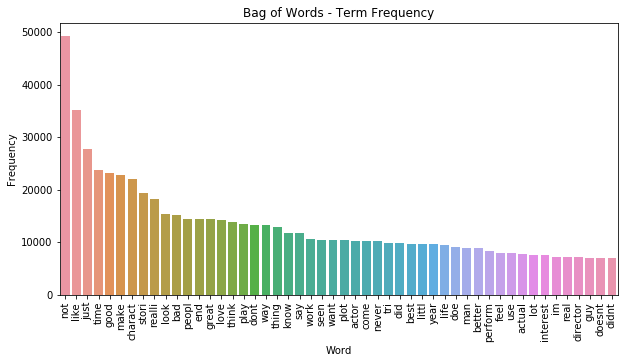

In [260]:
#plot the frequencies of the top 50 words.
vocabulary_sorted = list(words_freq.keys())
freq_sorted = list(words_freq.values())
plt.figure(figsize=(10,5))
s=sns.barplot(x=vocabulary_sorted[:50],y=freq_sorted[:50])
s.set_title('Bag of Words - Term Frequency')
s.set_xlabel('Word')
s.set_ylabel('Frequency')
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

##### <b> *we will fit 4 classifiers to the training data and compare them*</b>

In [261]:
# instantiate all classifiers with default settings
rf_clf = RandomForestClassifier(random_state=SEED)
nb_clf = MultinomialNB() #MultinomialNB works well with BOW sparse matrices
sgdsvc_clf =SGDClassifier(loss='hinge', random_state=SEED)
sgdlog_clf = SGDClassifier(loss='log', random_state=SEED)

In [262]:
#name of the classifiers in the same order as classifiers
names = ['Random Forest', 'Naive Bayes', 'SGD-Linear SVC', 'SGD-Logistic Regression']

In [263]:
# make a list of classifiers  
classifiers = [rf_clf, nb_clf, sgdsvc_clf, sgdlog_clf]

In [264]:
# Metrics of interest 
meancv_scores_list = []
accuracy_list = []
precision_list=[]
recall_list =[]
f1score_list=[]
kappa_list =[]

In [265]:
# for each classifier in the classifier above do the following
for clf in classifiers:
    
    #perform a 5-fold CV
    cv_scores = cross_val_score(clf,X_train_bow,y_train,cv=5)
    
    #append the mean of the cross val scores to the mean_cv_scores list
    meancv_scores_list.append(cv_scores.mean())
    
    # fit the classifier to the entire training set 
    clf.fit(X_train_bow, y_train)
    
    # predict test values
    y_pred = clf.predict(X_test_bow)
    
    # calculate and append the metrics of interest
    accuracy_list.append(accuracy_score(y_test, y_pred)) 
    precision_list.append(precision_score(y_test, y_pred))
    recall_list.append(recall_score(y_test, y_pred))
    f1score_list.append(f1_score(y_test, y_pred))
    kappa_list.append(cohen_kappa_score(y_test, y_pred))

In [266]:
#create a summary dataframe  
df_summary_bow = pd.DataFrame(list(zip(names, meancv_scores_list,accuracy_list,precision_list,recall_list,f1score_list,kappa_list)),
                          columns=['Classifier','Avg CV Score', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Kappa']
                         )

In [267]:
df_summary_bow

,Classifier,Avg CV Score,Accuracy,Precision,Recall,F1 Score,Kappa
0,Random Forest,0.836925,0.8374,0.843693,0.828166,0.835857,0.674799
1,Naive Bayes,0.838950,0.8315,0.830871,0.832366,0.831618,0.663000
2,SGD-Linear SVC,0.860950,0.8713,0.863636,0.881776,0.872612,0.742601
3,SGD-Logistic Regression,0.864975,0.8703,0.853784,0.893579,0.873228,0.740602


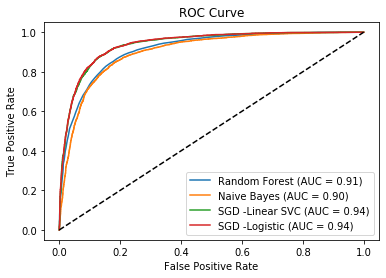

In [268]:
# plot the roc curve
fig, ax = plt.subplots()
plot_roc_curve(rf_clf, X_test_bow, y_test, name='Random Forest', ax=ax) #specify axis to plot all roc curves on the same axis
plot_roc_curve(nb_clf, X_test_bow, y_test, name='Naive Bayes', ax=ax)
plot_roc_curve(sgdsvc_clf, X_test_bow, y_test, name='SGD -Linear SVC',ax=ax)
plot_roc_curve(sgdlog_clf, X_test_bow, y_test, name='SGD -Logistic', ax=ax)
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.show()

In [269]:
#create a dataframe with model coefficents and feature names
df_coef_bow = pd.DataFrame({'features':  countvec.get_feature_names(),  'coef' : sgdsvc_clf.coef_.ravel()})
df_coef_bow.sort_values(by='coef', ascending=False, inplace=True)
df_coef_bow.reset_index(drop=True)

,features,coef
0,refresh,1.176675
1,high recommend,1.145436
2,funniest,0.989240
3,subtl,0.892052
4,hes not,0.867755
...,...,...
2495,worst,-1.107255
2496,unconvinc,-1.159320
2497,forgett,-1.180146
2498,not recommend,-1.398820


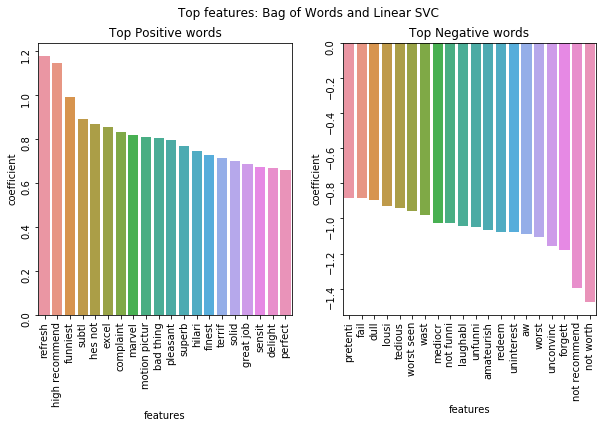

In [270]:
# top 20 positive and negative features
fig, ax = plt.subplots(1,2, figsize=(10,5))
sns.barplot(x=df_coef_bow.iloc[0:20, 0],y=df_coef_bow.iloc[0:20, 1], ax=ax[0])
ax[0].set_title('Top Positive words')
ax[0].set_ylabel('coefficient')
ax[0].tick_params(labelrotation=90)
sns.barplot(x=df_coef_bow.iloc[-20:, 0],y=df_coef_bow.iloc[-20:, 1], ax=ax[1])
ax[1].set_title('Top Negative words')
ax[1].set_ylabel('coefficient')
ax[1].tick_params(labelrotation=90)
plt.suptitle('Top features: Bag of Words and Linear SVC')
plt.show()

*Two Intesting observations : <br/>
i) Eventhough less than 1% of the features were bigrams, 6 bigrams (3 positive, 3 negative) made it to the top 20 list. <br/>
ii) The bigram 'high recommend' is the top 20 positive features while the bigram 'not recommend' is in the top20 negative features. The word 'recommend' itself is did not make the cut*

###  <font color='navy'>II. Prediction using TF-IDF sparse matrix and  multiple Classifiers</font>

In [271]:
#instantiate the Vectorizer
# Tfidf_vect  = TfidfVectorizer(max_features=MAX_FEATURES, stop_words=stop_words_stemmed, ngram_range=(1,2))
Tfidf_vect  = TfidfVectorizer(max_features=MAX_FEATURES, ngram_range=(1,2))

In [272]:
#similar to what we did before for countvec. 
bag_tfidf = Tfidf_vect.fit_transform(X_data_train) 

In [273]:
# Create X_train and X_test
X_train_tfidf= bag_tfidf.toarray() # scikit learn cant work with sparse matrices, so convert csr matrix to numpy array

# No refitting. Only transformation using the TfidfVectorizer fitted on training data.  otherwsie it would be cheating
X_test_tfidf = Tfidf_vect.transform(X_data_test).toarray()

In [274]:
# instantiate all classifiers with default settings
clf_rf = RandomForestClassifier(random_state=SEED)
clf_nb = MultinomialNB() 
clf_sgdsvc =SGDClassifier(loss='hinge', random_state=SEED)
clf_sgdlog = SGDClassifier(loss='log', random_state=SEED)

In [275]:
# make a list of classifiers  
classifiers = [clf_rf, clf_nb, clf_sgdsvc, clf_sgdlog]

In [276]:
#name of the classifiers in the same order as classifiers
names = ['Random Forest', 'Naive Bayes', 'SGD-Linear SVC', 'SGD-Logistic Regression']

In [277]:
# Metrics of interest 
mean_cv_scores = []
clf_accuracy = []
clf_precision=[]
clf_recall = []
clf_f1score=[]
clf_kappa =[]

In [278]:
# for each classifier in the classifier above do the following.
for clf in classifiers:
    
    #perform a 5-fold CV
    cv_scores = cross_val_score(clf,X_train_tfidf,y_train,cv=5)
    
    #append the mean of the cross val scores to the mean_cv_scores list
    mean_cv_scores.append(cv_scores.mean())
    
    # fit the classifier to the entire training set 
    clf.fit(X_train_tfidf, y_train)
    
    # predict test values
    y_pred = clf.predict(X_test_tfidf)
    
    # calculate and append the metrics of interest
    clf_accuracy.append(accuracy_score(y_test, y_pred)) 
    clf_precision.append(precision_score(y_test, y_pred))
    clf_recall.append(recall_score(y_test, y_pred))
    clf_f1score.append(f1_score(y_test, y_pred))
    clf_kappa.append(cohen_kappa_score(y_test, y_pred))

In [279]:
#create a summary dataframe  
df_summary = pd.DataFrame(list(zip(names, mean_cv_scores,clf_accuracy,clf_precision,clf_recall, clf_f1score,clf_kappa)),
                          columns=['Classifier','Avg CV Score', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Kappa']
                         )

In [280]:
df_summary

,Classifier,Avg CV Score,Accuracy,Precision,Recall,F1 Score,Kappa
0,Random Forest,0.840625,0.8438,0.845427,0.841368,0.843393,0.687600
1,Naive Bayes,0.843225,0.8402,0.834678,0.848370,0.841468,0.680401
2,SGD-Linear SVC,0.878500,0.8826,0.862559,0.910182,0.885731,0.765203
3,SGD-Logistic Regression,0.871375,0.8795,0.867209,0.896179,0.881456,0.759002


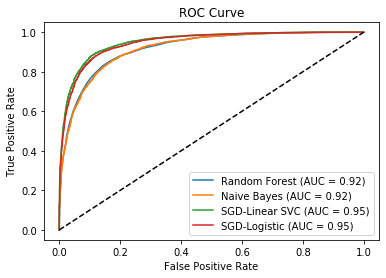

In [281]:
# plot the roc curve
fig, ax = plt.subplots()
plot_roc_curve(clf_rf, X_test_tfidf, y_test, name='Random Forest', ax=ax) #specify axis to plot all roc curves on the same axis
plot_roc_curve(clf_nb, X_test_tfidf, y_test, name='Naive Bayes', ax=ax)
plot_roc_curve(clf_sgdsvc, X_test_tfidf, y_test, name='SGD-Linear SVC', ax=ax)
plot_roc_curve(clf_sgdlog, X_test_tfidf, y_test, name='SGD-Logistic', ax=ax)
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.show()

In [282]:
# default alpha value is 0.0001
clf_sgdsvc.get_params()

{'alpha': 0.0001,
 'average': False,
 'class_weight': None,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'hinge',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': 1411,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

##### <b> *Fine tuning the best class (hyperparameter optimization)*</b>

In [283]:
# We set random_state for reproducibility 
clf_sgd = SGDClassifier(loss ='hinge', random_state=SEED)

# Instantiate the GridSearchCV object 
param_grid = {'alpha':[0.0001, 0.001, 0.01, 0.1, 1],  # alpha is the regularization parameter (higher alpha means more regulization) default is 0.0001
             }  

gs_sgd = GridSearchCV(estimator=clf_sgd, 
                      param_grid=param_grid, 
                      cv=5, 
                      scoring = 'roc_auc',
                    return_train_score=True,
                        verbose=0)

In [284]:
# run grid search (i.e fit training data)
gs_sgd.fit(X_train_tfidf, y_train)

GridSearchCV(cv=5, estimator=SGDClassifier(random_state=1411),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1]},
             return_train_score=True, scoring='roc_auc')

In [285]:
# get the top area under ROC curve (training set)
gs_sgd.best_score_

0.9494352619147772

In [286]:
# find the best estimator
gs_sgd.best_estimator_.get_params() 

{'alpha': 0.0001,
 'average': False,
 'class_weight': None,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'hinge',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': 1411,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [287]:
#actually the best model is still the model we got with the default setting !
gs_sgd.best_estimator_.get_params()== clf_sgdsvc.get_params()

True

In [288]:
#accuracy of the optimized model 
sgd_best = gs_sgd.best_estimator_
sgd_best.score(X_test_tfidf, y_test)

0.8826

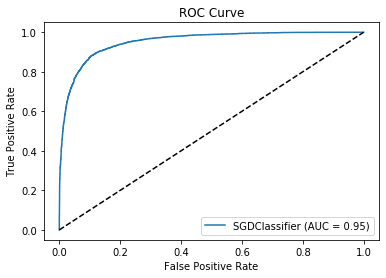

In [289]:
# plot roc curve 
plot_roc_curve(sgd_best, X_test_tfidf, y_test)
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.show()

In [290]:
# predict sentimet of test set
y_pred = sgd_best.predict(X_test_tfidf)

In [291]:
#print the confusion matrix (Note unlike R, in python the actuals obervations are given in rows and prediction in columns)
print(confusion_matrix(y_test, y_pred))

[[4276  725]
 [ 449 4550]]


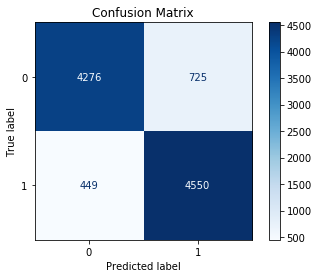

In [292]:
#plot confusion matrix counts.(Note unlike R, in scikit learn the True obervations are given in rows and prediction in columns)
plot_confusion_matrix(sgd_best, X_test_tfidf, y_test,cmap=plt.cm.Blues)  
plt.title('Confusion Matrix')
plt.show()

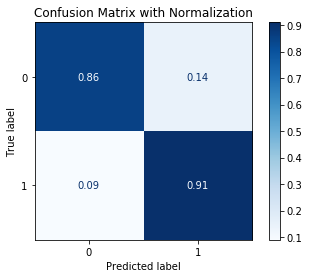

In [293]:
#plot confusion matrix normalized (Note unlike R, in scikit learn the true obervations are given in rows and prediction in columns)
plot_confusion_matrix(sgd_best, X_test_tfidf, y_test, cmap=plt.cm.Blues,normalize='true')  
plt.title('Confusion Matrix with Normalization')
plt.show()

In [294]:
# classification report 
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.86      0.88      5001
           1       0.86      0.91      0.89      4999

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [295]:
#create a dataframe with model coefficents and feature names
df_coef = pd.DataFrame({'features':  Tfidf_vect.get_feature_names(),  'coef' : sgd_best.coef_.ravel()})
df_coef.sort_values(by='coef', ascending=False, inplace=True)
df_coef.reset_index(drop=True)

,features,coef
0,excel,4.127614
1,great,4.028194
2,perfect,3.630314
3,brilliant,2.587052
4,enjoy,2.572353
...,...,...
2495,aw,-4.331460
2496,wast,-4.590394
2497,poor,-4.741538
2498,worst,-4.792715


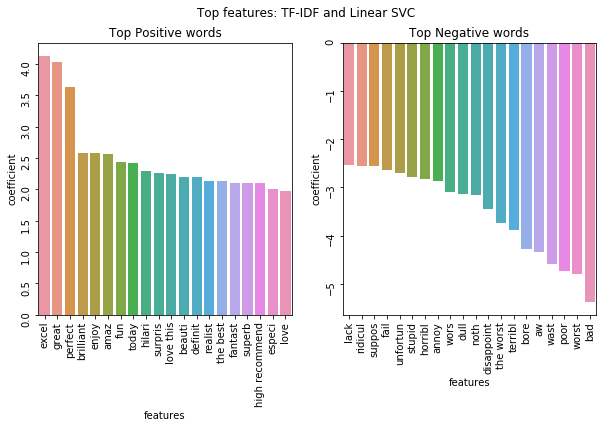

In [296]:
# top 20 postive and negative words
fig, ax = plt.subplots(1,2, figsize=(10,5))
sns.barplot(x=df_coef.iloc[0:20, 0],y=df_coef.iloc[0:20, 1], ax=ax[0])
ax[0].set_title('Top Positive words')
ax[0].set_ylabel('coefficient')
ax[0].tick_params(labelrotation=90)
sns.barplot(x=df_coef.iloc[-20:, 0],y=df_coef.iloc[-20:, 1], ax=ax[1])
ax[1].set_title('Top Negative words')
ax[1].set_ylabel('coefficient')
ax[1].tick_params(labelrotation=90)
plt.suptitle('Top features: TF-IDF and Linear SVC ')
plt.show()

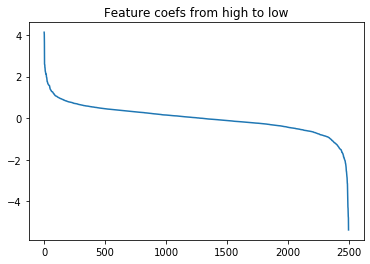

In [297]:
# L2 penatly shriks non-contributing coefficents towards zero (can aid in feature selection)
plt.plot(np.arange(0,2500), df_coef.coef)
plt.title('Feature coefs from high to low')
plt.show()

In [298]:
# out of the 2500 features only 262 has a coefficent >1
df_coef[abs(df_coef.coef)>1].shape[0]

262

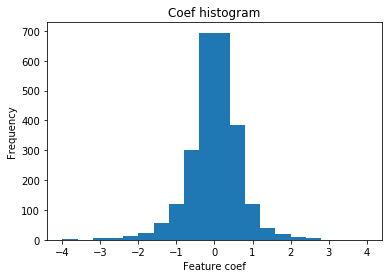

In [299]:
# features coefs historgram (same info presented differently)
plt.hist(df_coef.coef, bins=20, range=[-4,4])
plt.xlabel('Feature coef')
plt.ylabel('Frequency')
plt.title('Coef histogram')
plt.show()

### Appendix 1 : How many features ? 

*The choice of 2500 features was random (the idea was we would selected rouhgly 1% of the total unigrams). Here we will examine could we have done much better by selecting more features ? (by using the best class of model Linear SVC and tf-idf matrix)*

In [300]:
# max features to iterate over 
max_features_list = [250, 500, 1000, 2500, 5000, 10000, 15000, 20000]

#lists to save the results
accuracy_fs = []
roc_auc_fs=[]

for MAX_FEATURES in max_features_list:
    #instantiate the Vectorizer
    vect_tfidf  = TfidfVectorizer(max_features=MAX_FEATURES) 
    
    #create test and training sets (X variables)
    X_train_featureselect = vect_tfidf.fit_transform(X_data_train).A # dot A is the same as toarray()
    X_test_featureselect = vect_tfidf.transform(X_data_test).A
    
    # instantiate the Linear SVC classifier 
    sgd_logreg = SGDClassifier(loss='log', random_state=SEED)
    
    # train the model 
    sgd_logreg.fit(X_train_featureselect, y_train)
    
    # make prediction
    y_pred_fs = sgd_logreg.predict(X_test_featureselect)
    
    #append accuracy to the list 
    accuracy_fs.append(accuracy_score(y_test, y_pred_fs))
    
    # append roc curve to the list 
    y_pred_proba_fs = sgd_logreg.predict_proba(X_test_featureselect)[:,1]
    roc_auc_fs.append(roc_auc_score(y_test,y_pred_proba_fs))

In [301]:
#create a summary dataframe  
df_numfeatures = pd.DataFrame(list(zip(max_features_list, accuracy_fs,roc_auc_fs)),
                          columns=['No of features','Accuracy', 'ROC AUC']
                         )
df_numfeatures

,No of features,Accuracy,ROC AUC
0,250,0.7851,0.867994
1,500,0.8477,0.925178
2,1000,0.8654,0.938313
3,2500,0.8756,0.947095
4,5000,0.8802,0.949192
5,10000,0.8803,0.950184
6,15000,0.8791,0.950141
7,20000,0.8791,0.950076


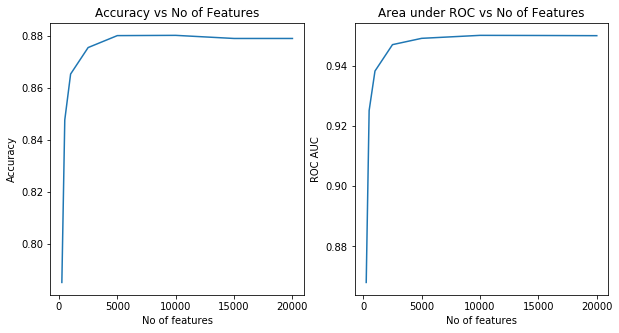

In [302]:
# plot no of featres vs accuracy 
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(df_numfeatures['No of features'], df_numfeatures['Accuracy'])
ax[0].set_title('Accuracy vs No of Features')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('No of features')
ax[1].plot(df_numfeatures['No of features'], df_numfeatures['ROC AUC'])
ax[1].set_title('Area under ROC vs No of Features')
ax[1].set_ylabel('ROC AUC')
ax[1].set_xlabel('No of features')
plt.show()

It looks like we could have done marginally better (a gain of 0.5% in accuracy) by choosing 5000 features. Beyond that adding more words does not improve the model

### Appendix 2 : Building a good model with less features

In [303]:
# we will start with the best model with 2500 features, recall it had only 262 features with coef greater than 1
df2 = df_coef[abs(df_coef.coef)>1]
my_vocabulary = list(df2.features)
len(my_vocabulary)

262

In [304]:
#instantiate the Vectorizer with the features with higher coefs only
Tfidf_vect_short  = TfidfVectorizer(vocabulary=my_vocabulary) 

# create training and test X variables
X_train_short = Tfidf_vect_short.fit_transform(X_data_train).A
X_test_short = Tfidf_vect_short.transform(X_data_test).A

In [305]:
# instantiate the classifer and train 
sgd_short = SGDClassifier(loss='log', random_state=SEED)
sgd_short.fit(X_train_short, y_train)
sgd_short.score(X_test_short, y_test)

0.8618

In [306]:
#calculate the area under ROC
y_pred_short = sgd_short.predict(X_test_short)

y_short_pred_proba =sgd_short.predict_proba(X_test_short)[:,1]
roc_auc_score(y_test,y_short_pred_proba)

0.9342513173700526

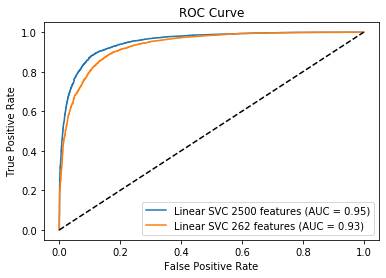

In [307]:
# plot roc curve 
fig, ax = plt.subplots()
plot_roc_curve(sgd_best, X_test_tfidf, y_test, name='Linear SVC 2500 features', ax=ax)
plot_roc_curve(sgd_short, X_test_short, y_test, name='Linear SVC 262 features', ax=ax)
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.show()

### Appendix 3 : Voting Classifer

In [308]:
classfier_list =[ ('random forest', clf_rf), ('SGD -Linear SVM', clf_sgdsvc),('SGD -Logistic', clf_sgdlog)]
# instantiate voting classifier VC
voting_clf = VotingClassifier(estimators = classfier_list, voting ='hard')
# hard voting => Majority decision

In [309]:
#fit vc to the training set and predict test labels
voting_clf.fit(X_train_tfidf, y_train)

VotingClassifier(estimators=[('random forest',
                              RandomForestClassifier(random_state=1411)),
                             ('SGD -Linear SVM',
                              SGDClassifier(random_state=1411)),
                             ('SGD -Logistic',
                              SGDClassifier(loss='log', random_state=1411))])

In [310]:
voting_clf.score(X_test_tfidf, y_test)

0.8831

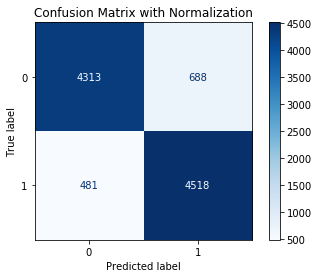

In [311]:
# plot confusion matrix for voting classifer normalized
plot_confusion_matrix(voting_clf, X_test_tfidf, y_test,cmap=plt.cm.Blues)  
plt.title('Confusion Matrix with Normalization')
plt.show()

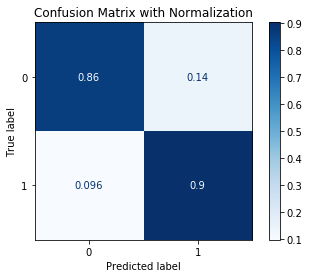

In [312]:
# plot confusion matrix for voting classifer normalized
plot_confusion_matrix(voting_clf, X_test_tfidf, y_test,cmap=plt.cm.Blues, normalize='true')  
plt.title('Confusion Matrix with Normalization')
plt.show()

### References and Possible Future Extensions